In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pqr


# Load and preprocess the data

In [3]:
prices = pd.read_excel("factors/russia/monthlyprice.xlsx", parse_dates=True, index_col=0)
pe = pd.read_excel("factors/russia/PE.xlsx", parse_dates=True, index_col=0)
volume = pd.read_excel("factors/russia/betafilter.xlsx", parse_dates=True, index_col=0)

prices, pe, volume = pqr.utils.replace_with_nan(prices, pe, volume, to_replace=0)

# Define stock universe, prepare factors and benchmark

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackMedian(3),
    pqr.Hold(3),
]

value = pqr.Factor(pe, better="less", preprocessor=preprocessor)

benchmark = pqr.Benchmark.from_universe(universe)

# Build a factor model

In [5]:
fm = pqr.fm.FactorModel(
    picking_strategies=pqr.fm.split_quantiles(3),
    allocation_strategy=pqr.EqualWeights(),
    add_wml=True
)

portfolios = fm(value, universe)

# Analyse the results

In [6]:
summary = pqr.dash.Dashboard(
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1, statistics=True),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark, statistics=True),
        pqr.metrics.Beta(benchmark),
    ),
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark, figsize=(16, 9)),
)

,Winners,Neutral 1,Losers,WML
"Mean Return, %",1.79*** (3.33),0.94** (1.81),1.42*** (2.69),0.37 (1.15)
"Volatility, %",7.70,7.43,7.55,4.65
Sharpe Ratio,0.81,0.44,0.65,0.28
"Mean Excess Return, %",6.59,-3.64,2.12,-10.42
"Alpha, %",7.87*** (3.15),-1.66 (-0.63),4.06 (1.43),3.81 (0.96)
Beta,0.91,0.87,0.87,0.04


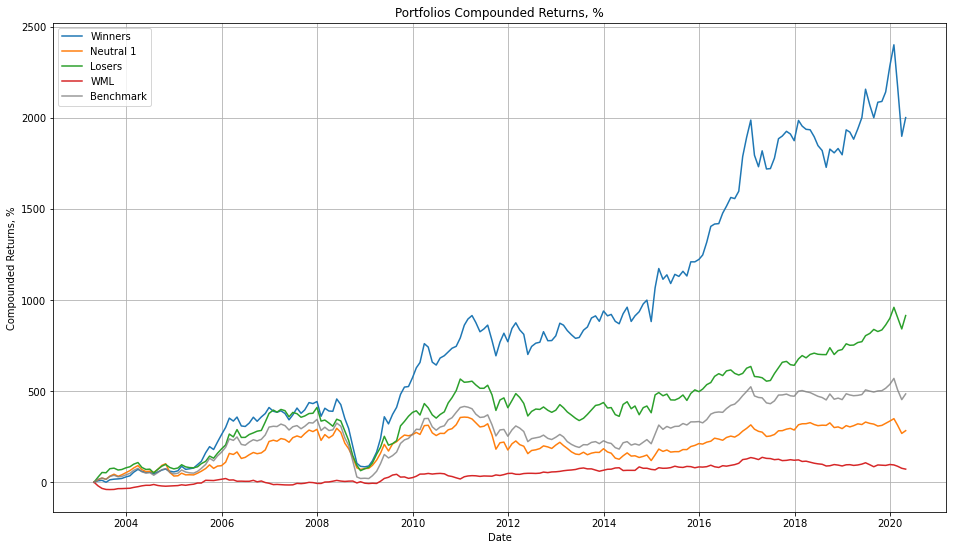

In [7]:
summary(portfolios)